In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In this work, the basic algorithms used in radar processing are explored to determine the position of an object and infer its movement. Processing is performed on ten reception windows of a pulsed radar, received at intervals of PRP time. The figure outlines how the work will be developed. The functionality of each block is as follows:

- **Adapted filter:** A linear filter whose impulse response is determined to maximize the Signal-to-Noise Ratio (SNR) at the filter output.
- **Moving Target Indicator (MTI) filter:** Exploits the correlation between signals from the same stationary object or low-speed object to mitigate them.
- **Stopped Target Indicator (STI) filter:** In contrast to MTI, this filter enhances signals from stationary objects.
- **Constant False Alarm Rate (CFAR) Threshold:** Estimates a decision threshold adaptively while maintaining a fixed false alarm rate.

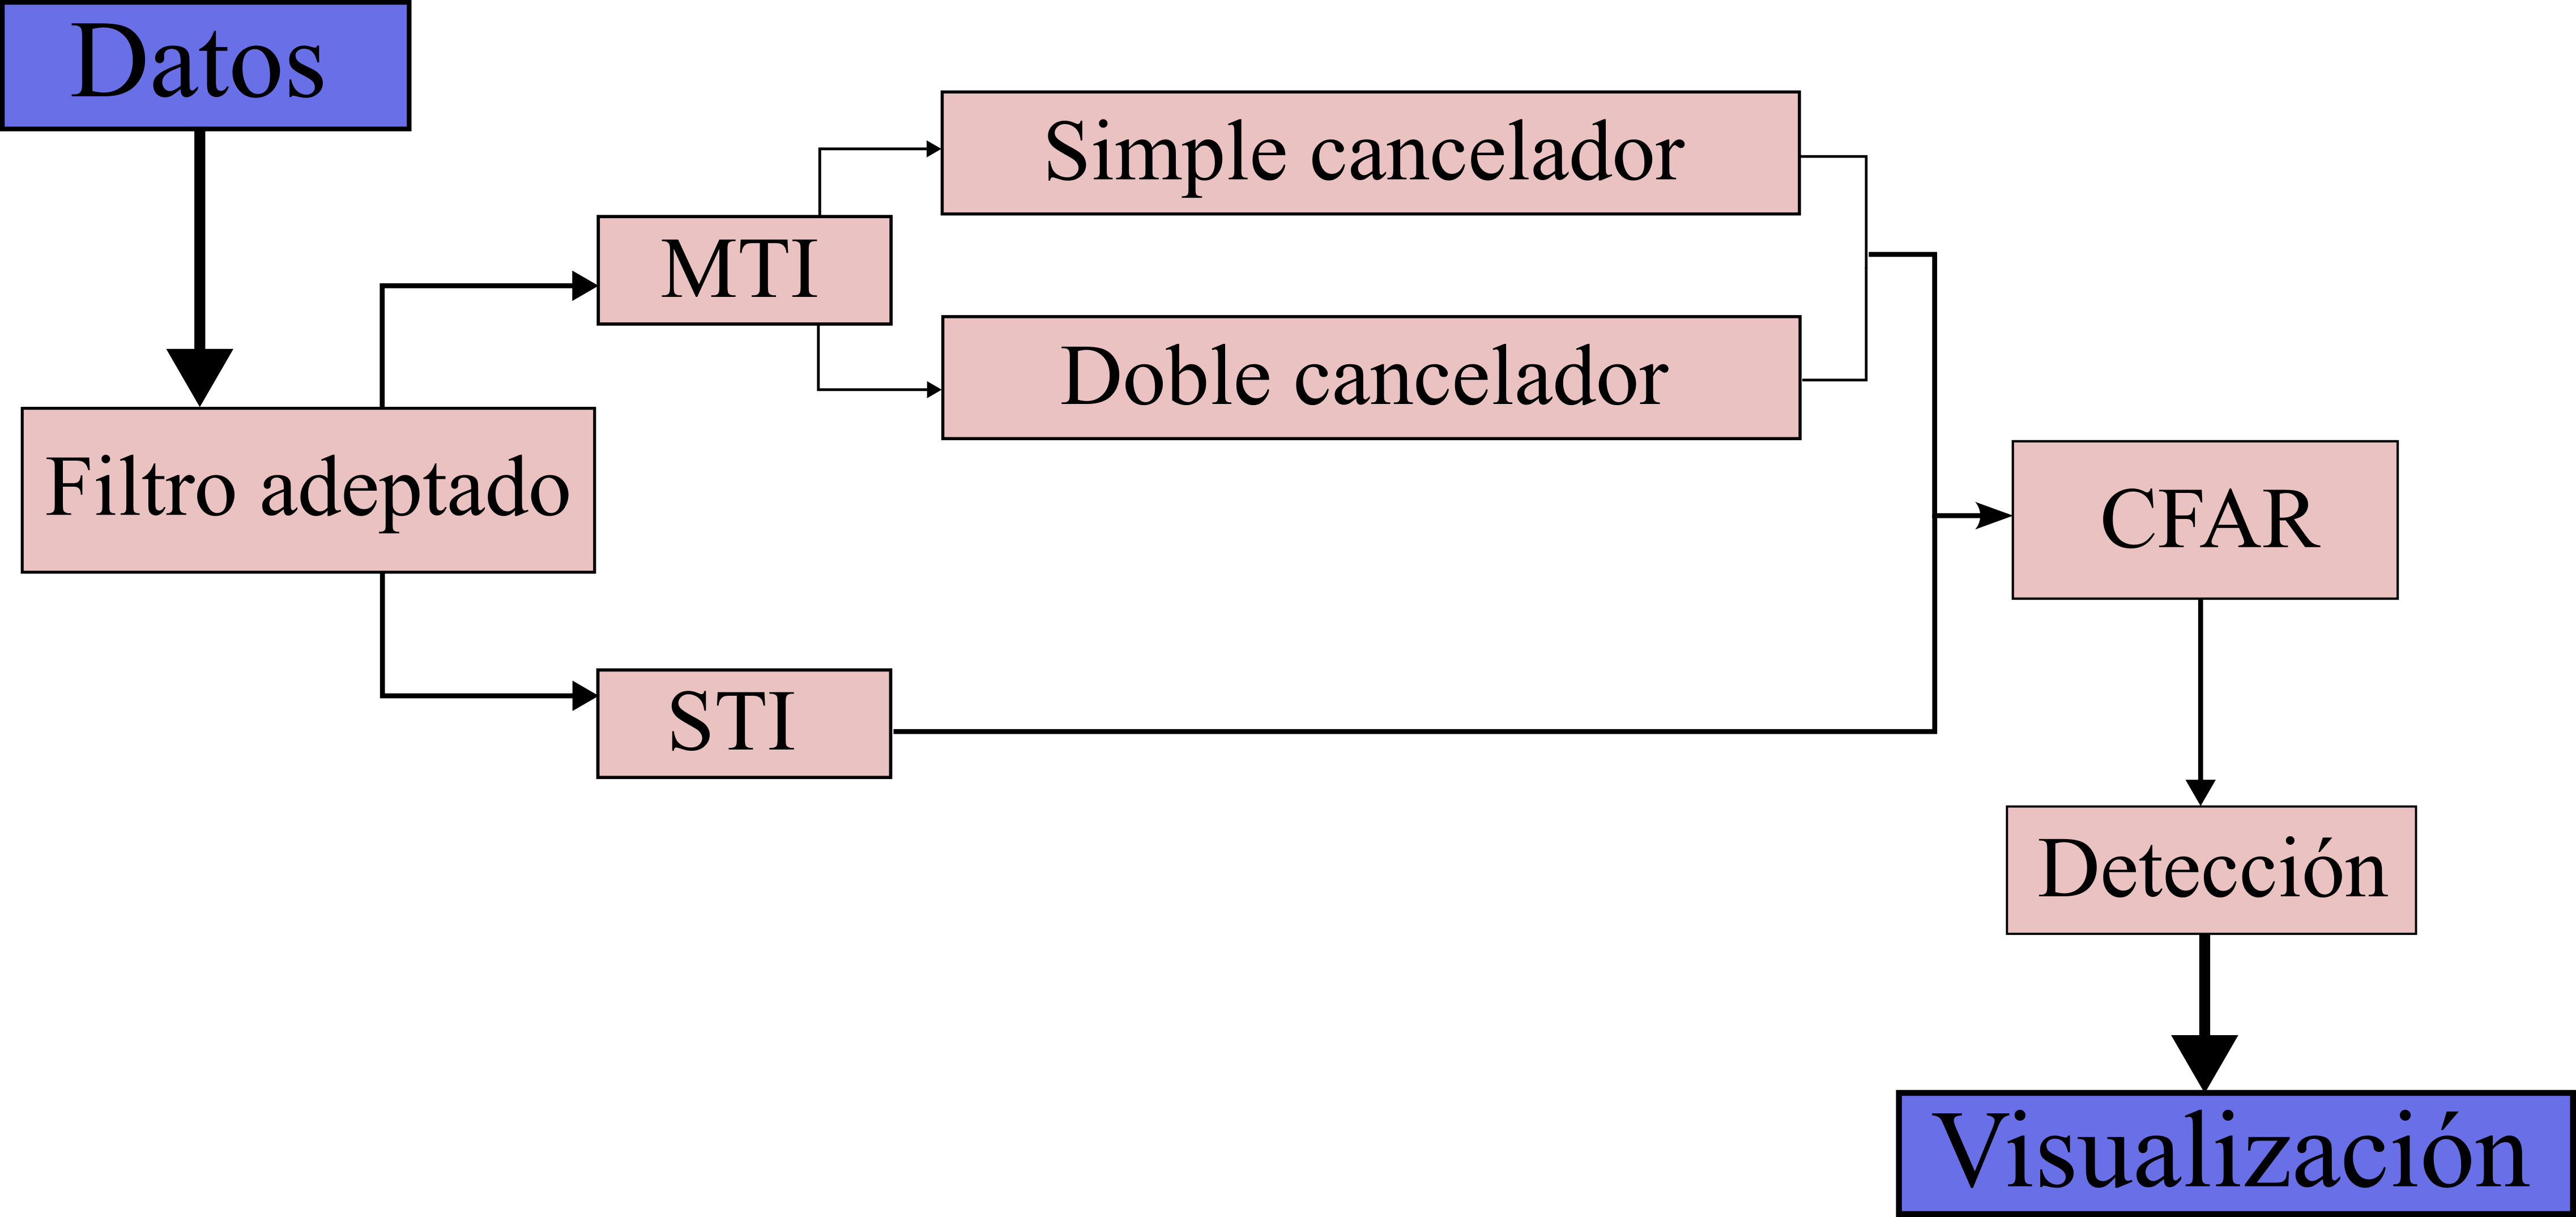

In [ ]:
# Load a Matlab file
mat = scipy.io.loadmat('radar_pulsado.mat')

# Extract parameters
s = mat.get('s')[:,0]      # transmitted signal
PRF = mat.get('PRF')[0,0]          # pulse repetition frequency
Tp = mat.get('T')[0,0]        # pulse time
T_out = mat.get('T_out')      # start and end of reception window
fc = mat.get('fc')[0,0]            # radar operating frequency
y = mat.get('y')
Np = mat.get('Np')
BW = mat.get('W')[0,0]
fs = mat.get('fs')[0,0]    # sampling frequency
rmax = mat.get('rmax')[0,0]
rmin = mat.get('rmin')[0,0]
ranges = mat.get('ranges')
vels = mat.get('vels')
PRP = 1/PRF


# **Signal**

## Original Chirp

Text(0.5, 1.0, 'Imaginary Part')

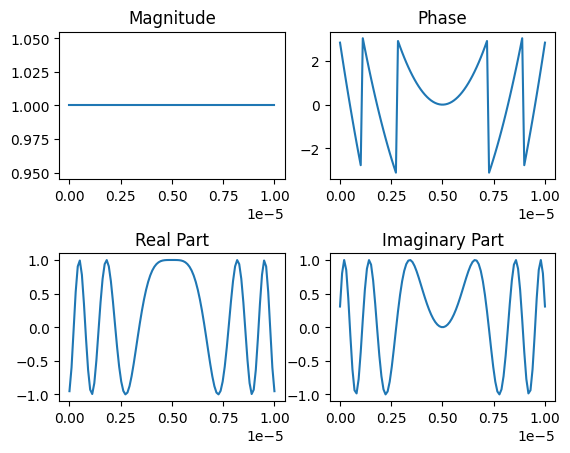

In [ ]:
s_real = np.real(s)
s_im = np.imag(s)

s_mod = np.abs(s)
s_ph = np.angle(s)

# Signal duration vector
t_s = np.linspace(0, Tp, 100)

fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)

ax[0,0].plot(t_s, s_mod)
ax[0,0].set_title("Magnitude")
ax[0,1].plot(t_s, s_ph)
ax[0,1].set_title("Phase")
ax[1,0].plot(t_s, s_real)
ax[1,0].set_title("Real Part")
ax[1,1].plot(t_s, s_im)
ax[1,1].set_title("Imaginary Part")

## Chirp generado

Text(0.5, 1.0, 'Imaginary Part')

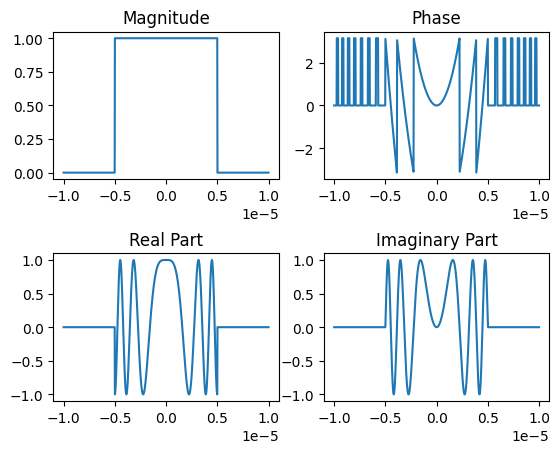

In [ ]:
# Generate my own chirp to have a signal with more points

# Rectangular function
def rect(x):
  if(x < 1/2 and x > -1/2):
    return 1
  else:
    return 0

# Chirp
def chirp(t, T, K):
  s = rect(t/T) * np.exp(1j * np.pi * K * t**2)
  return s

# Vector of duration of my own signal
t_s_my = np.linspace(-Tp, Tp, 1000)
K = BW / Tp

# My signal
s_my = [chirp(i, Tp, K) for i in t_s_my]

fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(hspace=0.5)

ax[0,0].plot(t_s_my, np.abs(s_my))
ax[0,0].set_title("Magnitude")
ax[0,1].plot(t_s_my, np.angle(s_my))
ax[0,1].set_title("Phase")
ax[1,0].plot(t_s_my, np.real(s_my))
ax[1,0].set_title("Real Part")
ax[1,1].plot(t_s_my, np.imag(s_my))
ax[1,1].set_title("Imaginary Part")


# **Reception Window**

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Range [km]')

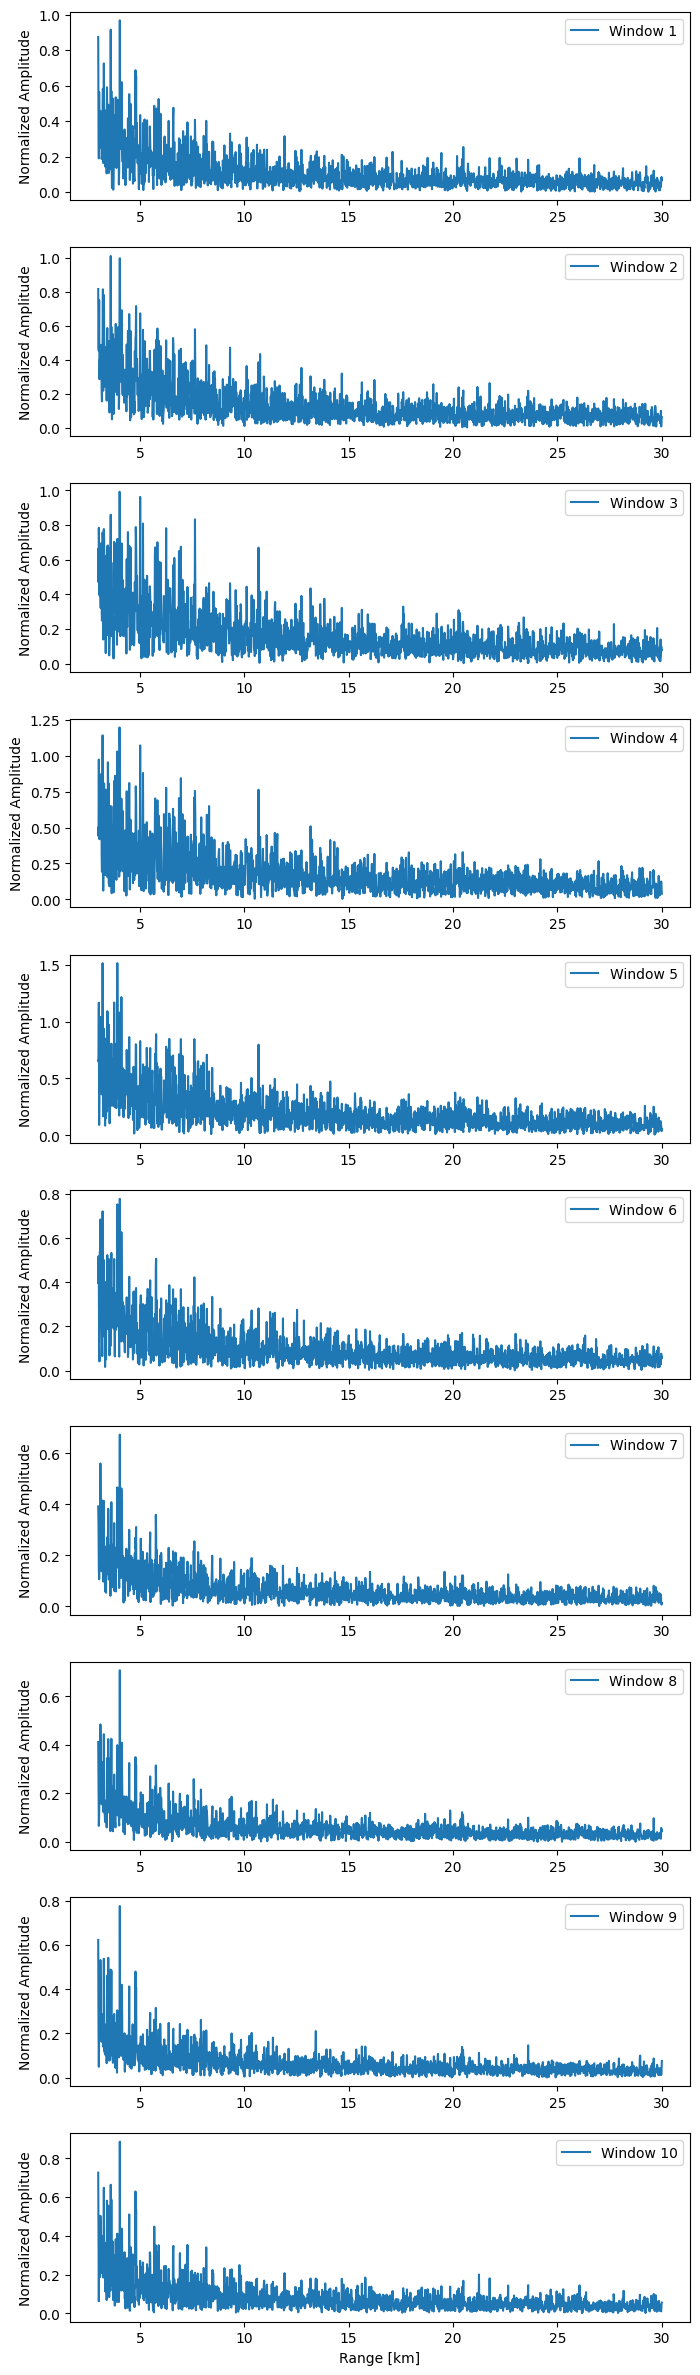

In [ ]:
# Display k reception windows
k = 10
# Range vector of a reception window
rang = np.linspace(rmin, rmax, len(y[:,0])) / 1000

fig, ax = plt.subplots(k, 1, figsize=(8, k*3))
plt.subplots_adjust(hspace=0.25)

for i in range(k):
  ax[i].plot(rang, (np.abs(y[:,i]) / max(y[:,i])), label="Window "+str(i+1))
  ax[i].set_ylabel("Normalized Amplitude")
  ax[i].legend()

ax[k-1].set_xlabel("Range [km]")


# **Adaptated Filter**

To clean the signal from this noise, an adapted filter is employed to maximize the SNR. To achieve this, the impulse response should have the form:

$ h(t) = s^*(t_0 - t) $

Where $t_0$ is the delay of the signal. Knowing this, the adapted filter was constructed using the signal data considering $t_0 = 0$. Once this filter was applied, it was possible to distinguish some signals. A comparison is made between the signal before and after the filter for the first two reception windows. In both cases, peaks are observed that were not distinguishable before this stage. Within window 1, the peaks located at distances of 20 and 25 km stand out, while in window 2, no peak is observed at 20 km, although one is visualized at 25 km.


## Generate the adapted filter from the given signal

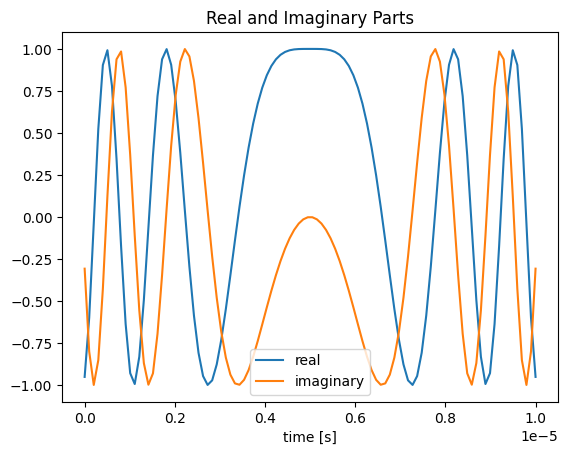

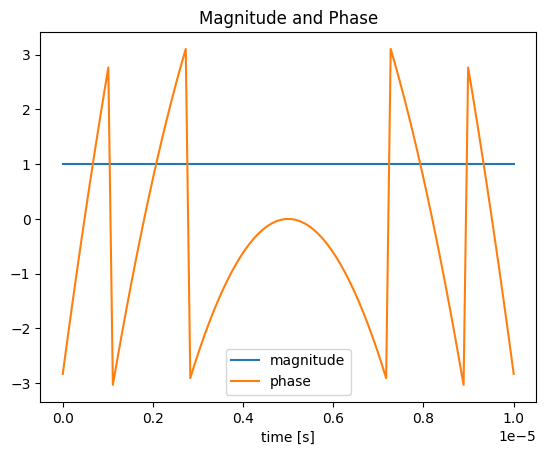

In [ ]:
# Filter made with the provided signal
size_s = len(s)         # size of my signal

h_s = np.zeros(size_s, dtype=np.complex128)  # Initialize as complex double precision numbers

for i in range(0, size_s):
  h_s[i] = np.conjugate(s[i])

plt.figure()
plt.plot(t_s, np.real(h_s), label="real")
plt.plot(t_s, np.imag(h_s), label="imaginary")
plt.title("Real and Imaginary Parts")
plt.xlabel("time [s]")
plt.legend()

plt.figure()
plt.plot(t_s, np.abs(h_s), label="magnitude")
plt.plot(t_s, np.angle(h_s), label="phase")
plt.title("Magnitude and Phase")
plt.xlabel("time [s]")
plt.legend()

## Convolution of the filter with $s(t)$

Text(0.5, 0, 'tiempo [us]')

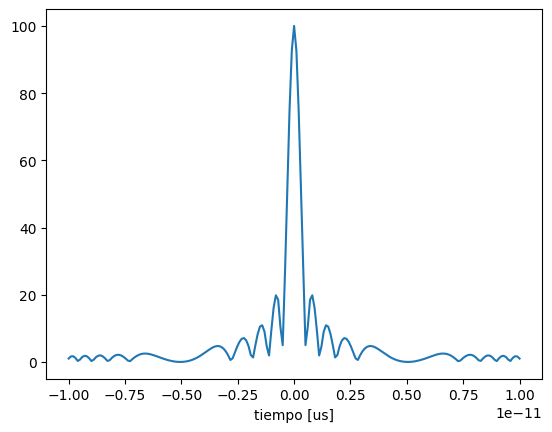

In [ ]:
# vector de tiempo de la convolución
t_conv_s = 1e-6*np.linspace(-Tp,Tp, 2*len(s)-1)

# Realizar la convolución
s_out = np.convolve(s, h_s, mode='full')

# Imprimir el resultado
plt.plot(t_conv_s, np.abs(s_out))
plt.xlabel("tiempo [us]")


## Apply adapted filter to each signal in the data vector

Plot the first k windows in separate plots.

Text(0.5, 0, 'Range [km]')

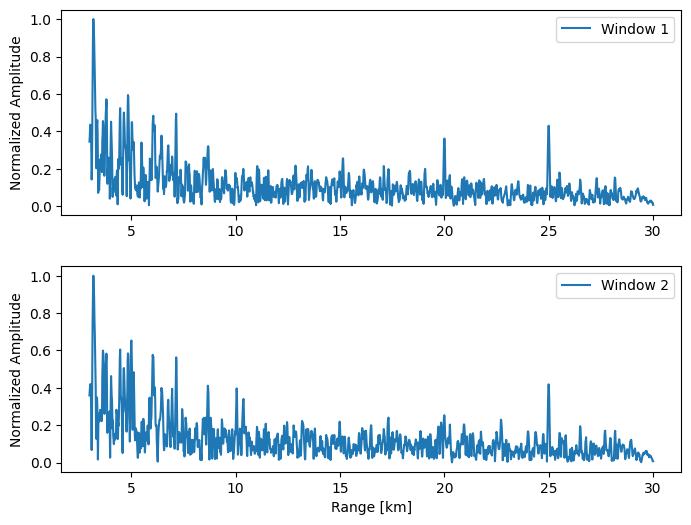

In [ ]:
sz_v = len(y[:,0])      # size of the window
sz_h = len(h_s)         # size of the filter

# number of windows to plot
k = 2

y_conv = []

fig, ax = plt.subplots(k, 1, figsize=(8, k*3))
plt.subplots_adjust(hspace=0.25)

for i in range(k):
  y_conv_i = np.convolve(y[:,i], h_s, mode='full')
  y_conv.append(y_conv_i[sz_h-1:])
  ax[i].plot(rang, np.abs(y_conv_i[sz_h-1:]) / max(np.abs(y_conv_i[sz_h-1:])), label="Window "+str(i+1))
  ax[i].set_ylabel("Normalized Amplitude")
  ax[i].legend()

ax[k-1].set_xlabel("Range [km]")

Plot the first k windows.

Text(0.5, 0, 'Range [km]')

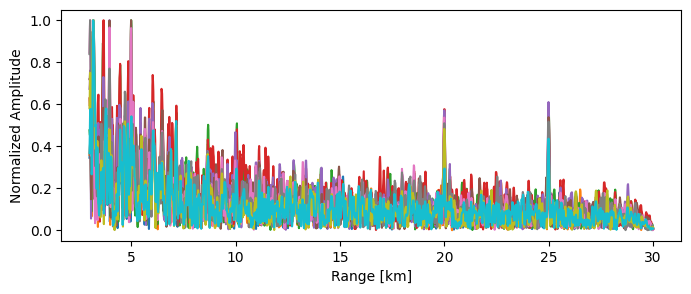

In [ ]:
# number of windows to plot
k = 10

y_conv = []

fig, ax = plt.subplots(figsize=(8, 1*3))
plt.subplots_adjust(hspace=0.25)

for i in range(k):
  y_conv_i = np.convolve(y[:,i], h_s, mode='full')
  y_conv.append(y_conv_i[sz_h-1:])
  ax.plot(rang, np.abs(y_conv_i[sz_h-1:]) / max(np.abs(y_conv_i[sz_h-1:])))

ax.set_ylabel("Normalized Amplitude")
ax.set_xlabel("Range [km]")


Compare the original signal with the filtered signal.


Text(0.5, 0, 'Range [km]')

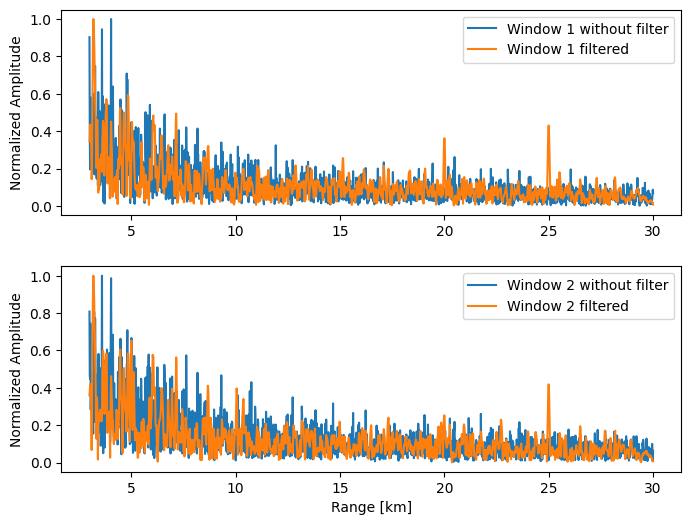

In [ ]:
k = 2

# Comparison
fig, ax = plt.subplots(k, 1, figsize=(8, k*3))
plt.subplots_adjust(hspace=0.25)

for i in range(k):
  ax[i].plot(rang, (np.abs(y[:,i]) / max(np.abs(y[:,i]))), label="Window "+str(i+1)+" without filter")
  ax[i].plot(rang, (np.abs(y_conv[i]) / max(np.abs(y_conv[i]))), label="Window "+str(i+1)+" filtered")
  ax[i].set_ylabel("Normalized Amplitude")
  ax[i].legend()

ax[k-1].set_xlabel("Range [km]")

# **Moving Target Indicator (MTI) Canceller Filter**

The Figure shows a scheme of an MTI filter, where its impulse response can be observed as follows:

$ H(z) = 1 + h_1z^{-1} + h_2z^{-2} $

The algorithm for performing such filtration involves summing consecutive windows multiplied by the coefficients $ h_1 $ and $ h_2$, so that the amplitude of signals that do not change their phase is reduced at the output.

For the case of a single canceller, two consecutive windows are subtracted, meaning that $h_1 = -1$ and $h_2 = 0$, while for the case of a double canceller, $h_1 = -2$ and $h_2 = 1$.

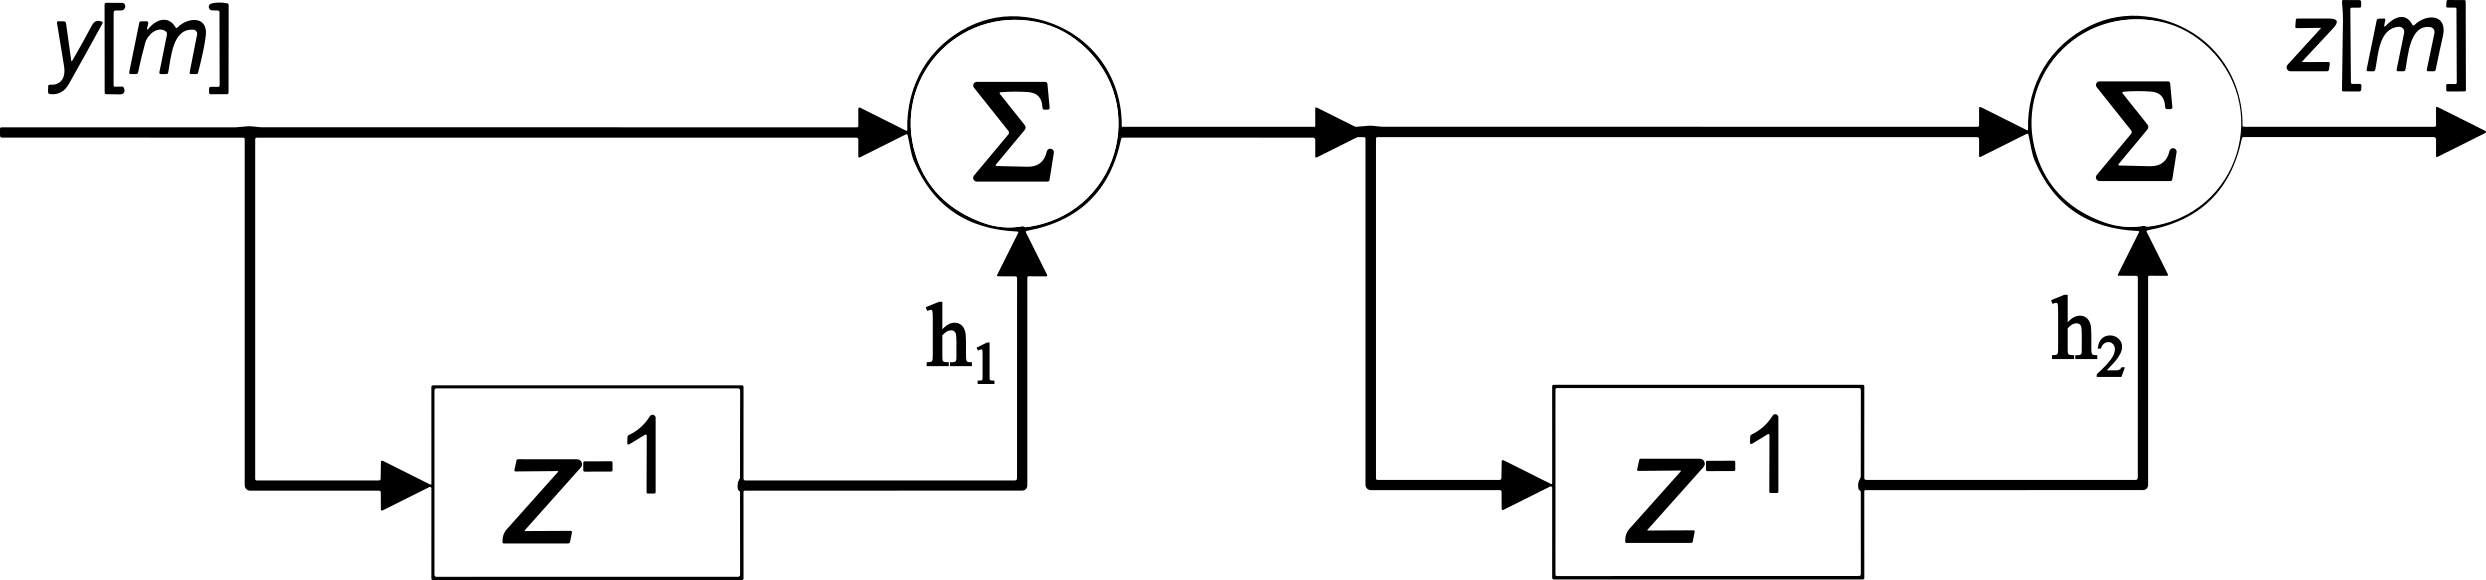


## **Simple Canceller**

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Average')

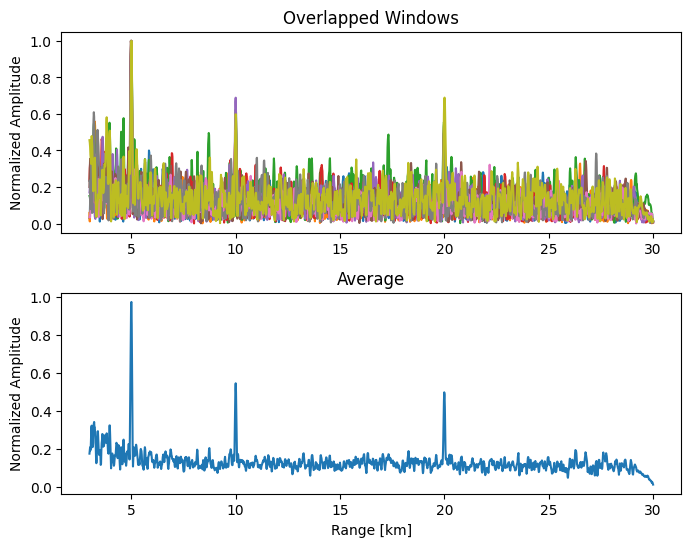

In [32]:
y_MTI = []

fig, ax = plt.subplots(2, 1, figsize=(8, 2*3))
plt.subplots_adjust(hspace=0.3)

for i in range(0, 9):
  y_MTI_i = y_conv[i+1] - y_conv[i]
  y_MTI.append(y_MTI_i)

  ax[0].plot(rang, abs(y_MTI_i) / max(abs(y_MTI_i)))
  ax[0].set_ylabel("Normalized Amplitude")

ax[0].set_title("Overlapped Windows")

# Averaging
prom = np.zeros(len(y_MTI[0]), dtype=np.complex128)
for i in range(0, 9):
  prom = prom + abs(y_MTI[i]) / max(abs(y_MTI[i]))

prom = prom / 9

ax[1].plot(rang, prom)
ax[1].set_ylabel("Normalized Amplitude")
ax[1].set_xlabel("Range [km]")
ax[1].set_title("Average")

Text(0.5, 0, 'rango [km]')

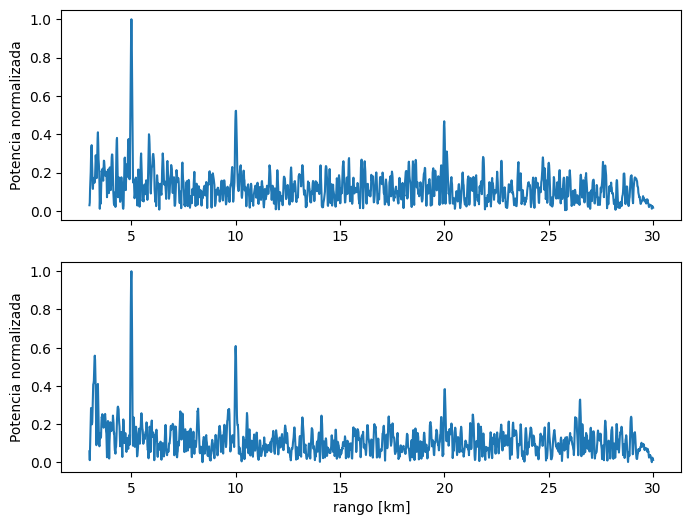

In [21]:
k = 2

fig, ax = plt.subplots(k,1, figsize = (8,k*3))
plt.subplots_adjust(hspace=0.2)

for i in range(0,k):
  ax[i].plot(rang, np.abs(y_MTI[i])/max(np.abs(y_MTI[i])), "Windows " + str(k) + "proccessed")
  ax[i].set_ylabel("Potencia normalizada")
  ax[i].legend()



ax[k-1].set_xlabel("rango [km]")

## **Double canceller**

Text(0.5, 1.0, 'Average')

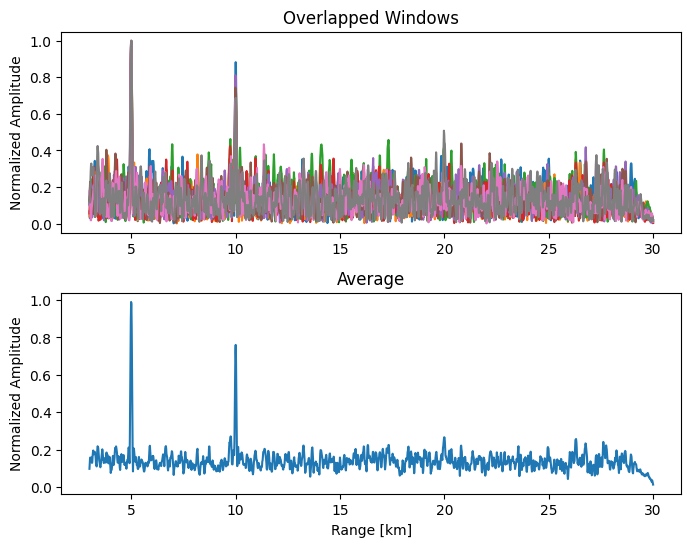

In [22]:
y_MTI2 = []

fig, ax = plt.subplots(2, 1, figsize=(8, 2*3))
plt.subplots_adjust(hspace=0.3)

for i in range(0, 8):
  y_MTI_i = y_conv[i+2] - 2*y_conv[i+1] + y_conv[i]
  y_MTI2.append(y_MTI_i)

  ax[0].plot(rang, abs(y_MTI_i) / max(abs(y_MTI_i)))
  ax[0].set_ylabel("Normalized Amplitude")

ax[0].set_title("Overlapped Windows")

# Averaging
prom2 = np.zeros(len(y_MTI2[0]), dtype=np.complex128)
for i in range(0, 8):
  prom2 = prom2 + abs(y_MTI2[i]) / max(abs(y_MTI2[i]))

prom2 = prom2 / 8

ax[1].plot(rang, prom2)
ax[1].set_ylabel("Normalized Amplitude")
ax[1].set_xlabel("Range [km]")
ax[1].set_title("Average")


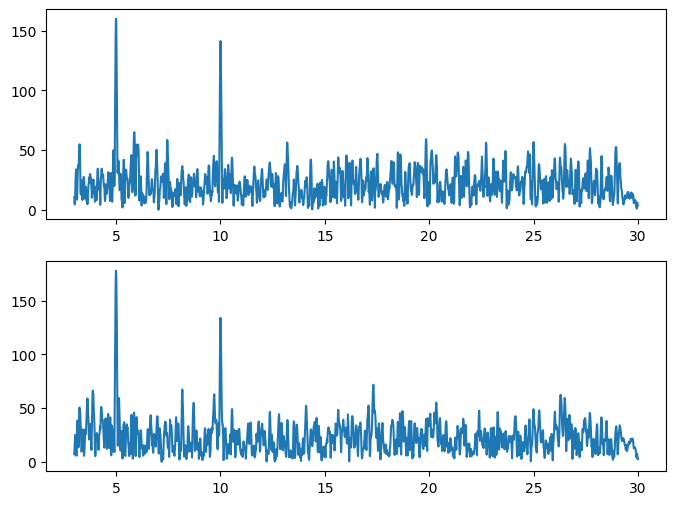

In [26]:
k = 2
fig, ax = plt.subplots(k,1, figsize = (8,k*3))
plt.subplots_adjust(hspace=0.2)

for i in range(0,k):
  ax[i].plot(rang, np.abs(y_MTI2[i]))

# **Stopped Target Indicator (STI) Filter**
The STI filter is similar to an MTI filter with coefficients $h0 = h1 = 1$.

Text(0.5, 0, 'Range [km]')

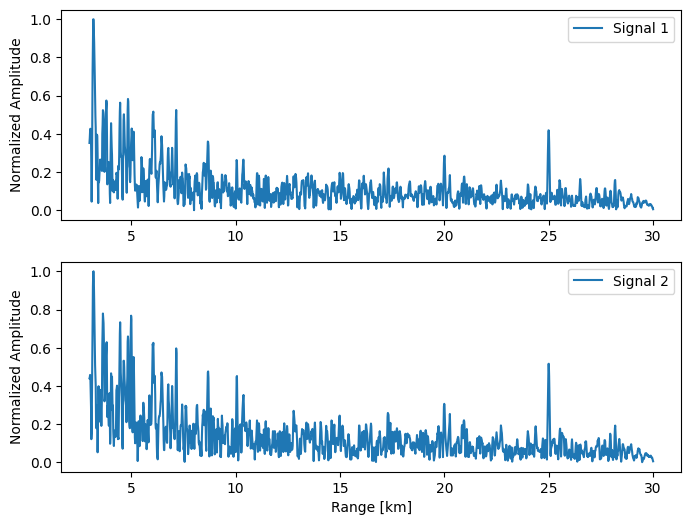

In [37]:
y_STI = []

k = 2

for i in range(0, k):
  y_STI_i = y_conv[i+1] + y_conv[i]
  y_STI.append(y_STI_i)

fig, ax = plt.subplots(k, 1, figsize=(8, k*3))
plt.subplots_adjust(hspace=0.2)

for i in range(0, k):
  ax[i].plot(rang, np.abs(y_STI[i]) / max(np.abs(y_STI[i])), label="Signal "+str(i+1))
  ax[i].legend()
  ax[i].set_ylabel("Normalized Amplitude")

ax[k-1].set_xlabel("Range [km]")

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Average')

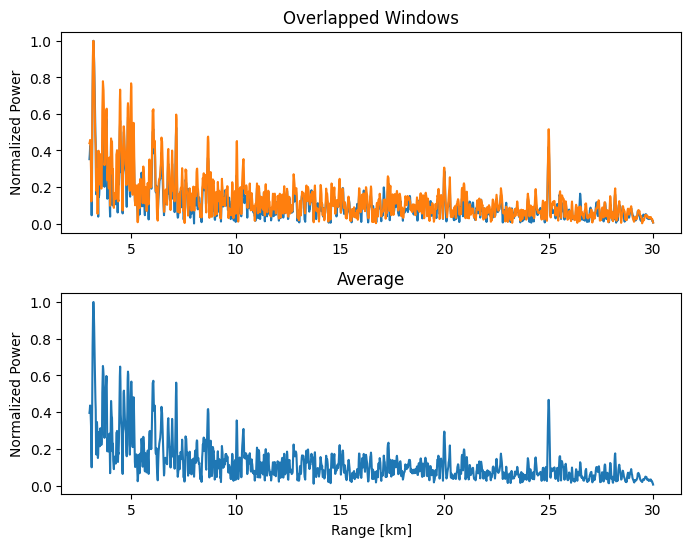

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(8, k*3))
plt.subplots_adjust(hspace=0.3)

for i in range(0, k):
  ax[0].plot(rang, np.abs(y_STI[i]) / max(np.abs(y_STI[i])))

ax[0].set_title("Overlapped Windows")
ax[0].set_ylabel("Normalized Power")

# Averaging
prom_sti = np.zeros(len(y_STI[0]), dtype=np.complex128)
for i in range(0, k):
  prom_sti = prom_sti + abs(y_STI[i]) / max(abs(y_STI[i]))

prom_sti = prom_sti / k

ax[1].plot(rang, prom_sti)
ax[1].set_ylabel("Normalized Power")
ax[1].set_xlabel("Range [km]")
ax[1].set_title("Average")


# **Constant False Alarm Rate (CFAR) Threshold**

This threshold, CF, is adaptively constructed for each point of the squared magnitude of the signal, $y_i$, from its non-immediate surrounding $N$ points, $k$, as follows:

$CF_i = \alpha \sum_{j=0}^{N} k_j$

where α is a factor depending on the false alarm probability, Pfa, as follows:

$\alpha = N(P_{fa}^{-1/N} - 1)$


Text(0.5, 0, 'Range [km]')

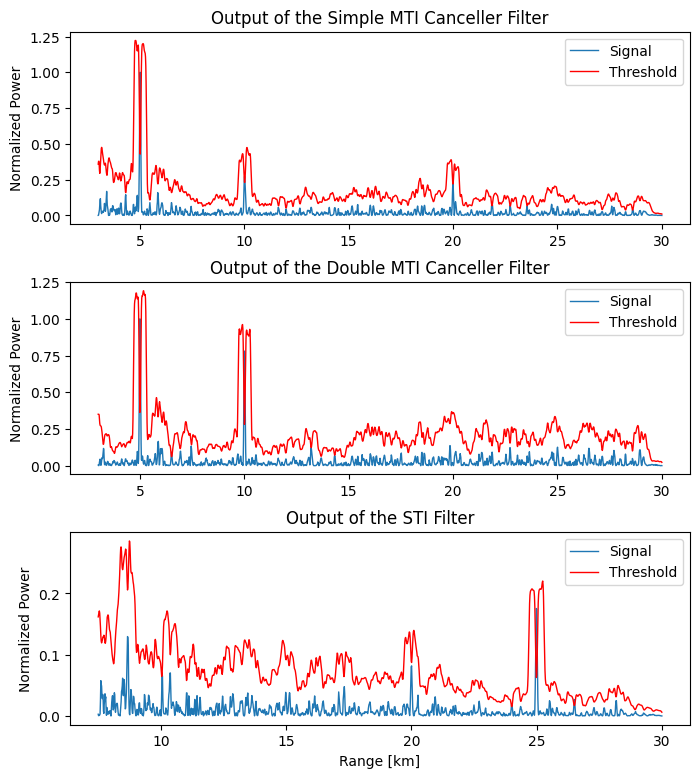

In [50]:
N = 100                        # Number of cells   ~20-G
G = 10                         # Guard Cells   ~2
Pfa = 0.01                     # Probability of false alarm

# It can be done by convolution

def CFAR(y, N, G, Pfa):
  alpha = 2*(N-G)*(Pfa**(-1/(2*(N-G)))-1)      # threshold factor
  CFAR = []

  for i in range(0, len(y)):
    Pn = 0                        # Estimated noise power
    cont = 0
    for j in range(i-N, i+N+1):
      if((j > 0 and j < len(y)) and (j < i-G or j > i+G)):
        Pn = Pn + np.abs(y[j])
        cont += 1
    Pn = Pn / cont
    CFAR.append(alpha * Pn)

  return CFAR

N = 20                        # Number of cells
G = 2                         # Guard Cells
Pfa = 0.001                   # Probability of false alarm

fig, ax = plt.subplots(3, 1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.3)

i = 0

ax[0].plot(rang, (np.abs(y_MTI[i]) / max(np.abs(y_MTI[i])))**2, label="Signal", linewidth=1)
ax[0].plot(rang, CFAR((np.abs(y_MTI[i]) / max(np.abs(y_MTI[i])))**2, N, G, Pfa), 'r', label="Threshold", linewidth=1)
ax[0].set_ylabel("Normalized Power")
ax[0].set_title("Output of the Simple MTI Canceller Filter")
ax[0].legend()

ax[1].plot(rang, (np.abs(y_MTI2[i] / max(np.abs(y_MTI2[i]))))**2, label="Signal", linewidth=1)
ax[1].plot(rang, CFAR((np.abs(y_MTI2[i] / max(np.abs(y_MTI2[i]))))**2, N, G, Pfa), 'r', label="Threshold", linewidth=1)
ax[1].set_ylabel("Normalized Power")
ax[1].set_title("Output of the Double MTI Canceller Filter")
ax[1].legend()

m = 300
z = (np.abs(y_STI[i] / max(np.abs(y_STI[i]))))**2
z_cfar = CFAR((np.abs(y_STI[i] / max(np.abs(y_STI[i]))))**2, N, G, Pfa)
ax[2].plot(rang[m:], z[m:], label="Signal", linewidth=1)
ax[2].plot(rang[m:], z_cfar[m:], 'r', label="Threshold", linewidth=1)
ax[2].set_ylabel("Normalized Power")
ax[2].set_title("Output of the STI Filter")
ax[2].legend()

ax[2].set_xlabel("Range [km]")


## **Application of the CFAR threshold to the output signal of the simple MTI canceller filter**

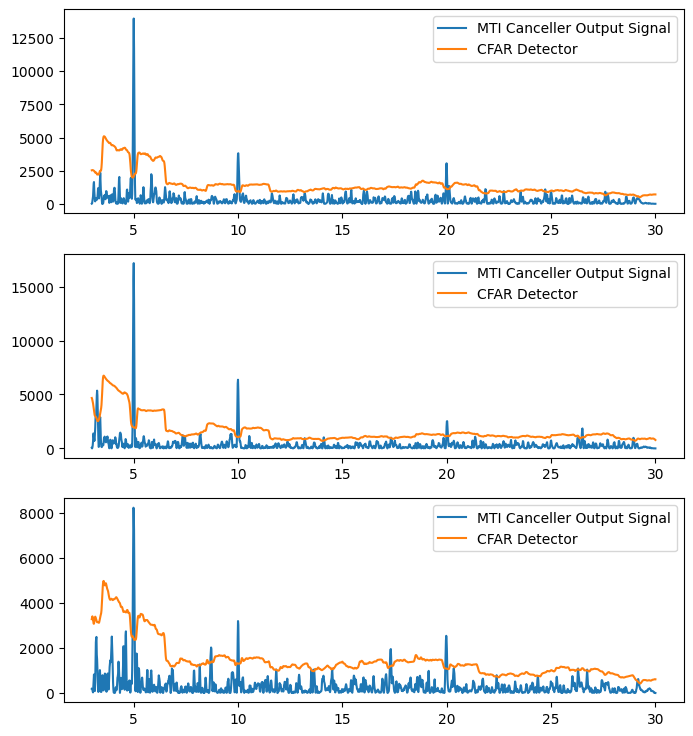

In [53]:
N = 100                        # Number of cells
G = 10                         # Guard Cells
Pfa = 0.01                     # Probability of false alarm

k = 3

fig, ax = plt.subplots(k, 1, figsize=(8, 3*k))
plt.subplots_adjust(hspace=0.2)

for i in range(0, k):
  ax[i].plot(rang, np.abs(y_MTI[i])**2, label="MTI Canceller Output Signal")
  ax[i].plot(rang, CFAR(np.abs(y_MTI[i])**2, N, G, Pfa), label="CFAR Detector")
  ax[i].legend()

## **Application of the CFAR threshold to the output signal of the double MTI canceller filter**

> Añadir blockquote



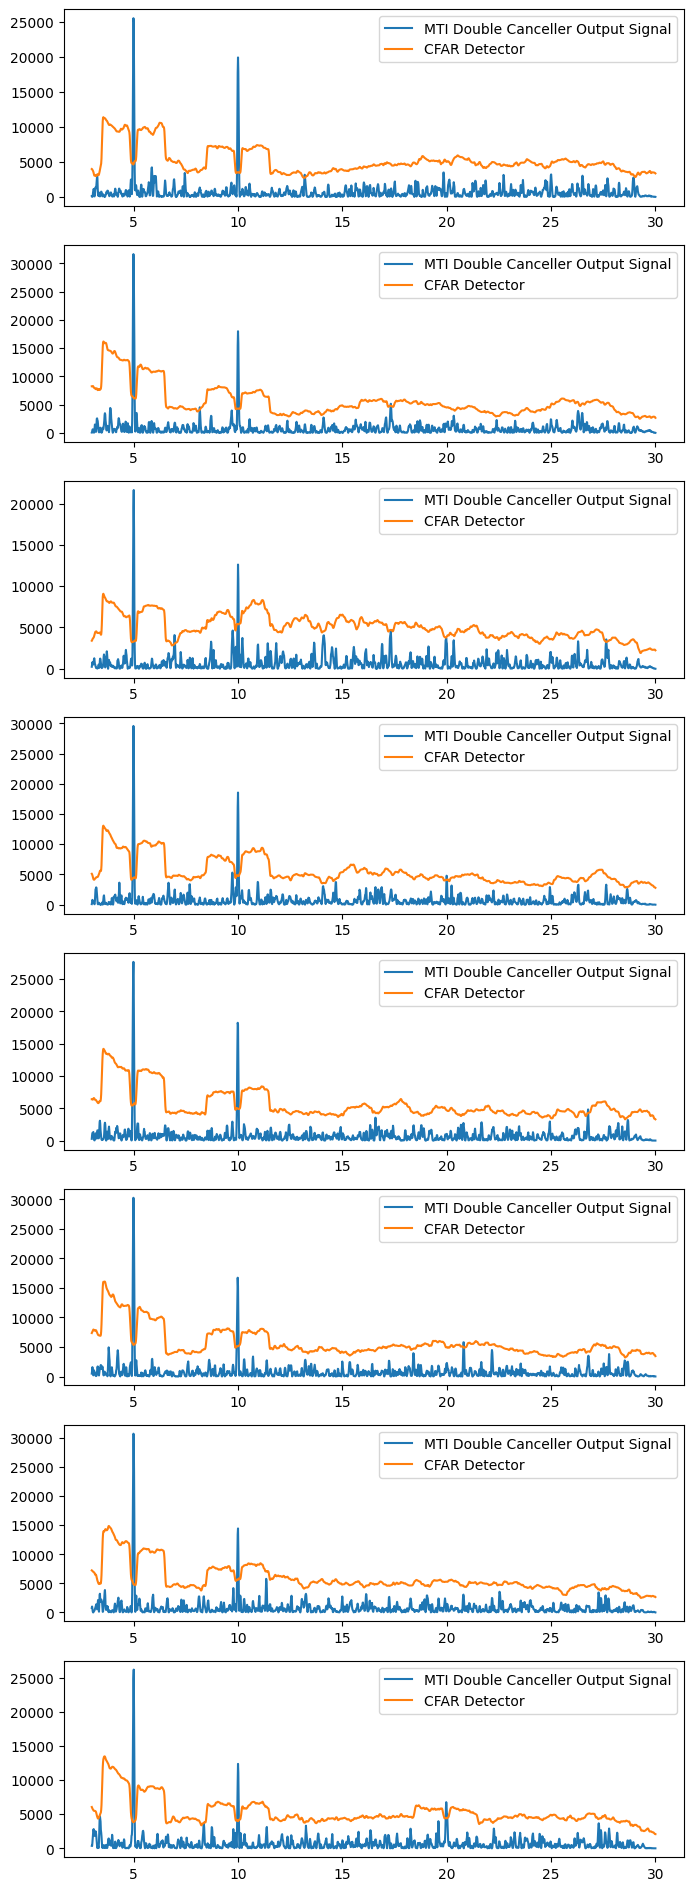

In [55]:
N = 100                        # Number of cells
G = 10                         # Guard Cells
Pfa = 0.001                    # Probability of false alarm

k = 8

fig, ax = plt.subplots(k, 1, figsize=(8, 3*k))
plt.subplots_adjust(hspace=0.2)

for i in range(0, k):
  ax[i].plot(rang, np.abs(y_MTI2[i])**2, label="MTI Double Canceller Output Signal")
  ax[i].plot(rang, CFAR(np.abs(y_MTI2[i])**2, N, G, Pfa), label="CFAR Detector")
  ax[i].legend()


## **Application of the CFAR threshold to the output signal of the STI filter**


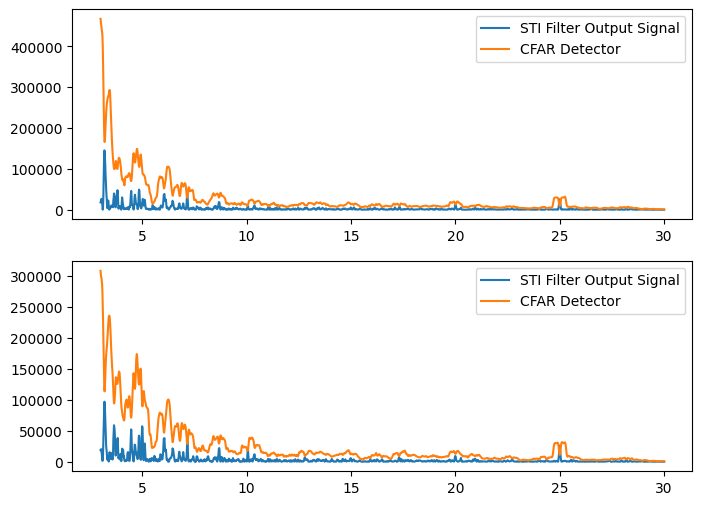

In [66]:
N = 20                         # Number of cells
G = 2                          # Guard Cells
Pfa = 0.001                    # Probability of false alarm

fig, ax = plt.subplots(2, 1, figsize=(8, 3*2))
plt.subplots_adjust(hspace=0.2)

for i in range(0, 2):
  ax[i].plot(rang, np.abs(y_STI[i])**2, label="STI Filter Output Signal")
  ax[i].plot(rang, CFAR(np.abs(y_STI[i])**2, N, G, Pfa), label="CFAR Detector")
  ax[i].legend()


#**Binary Detector**

For detection, a binary detector is implemented, from which it is decided whether a peak corresponds to an object or not. It is considered that the detection of a peak corresponds to the presence of an object when in more than half of the windows, it exceeds the CFAR threshold.

Text(0.5, 0, 'Range [km]')

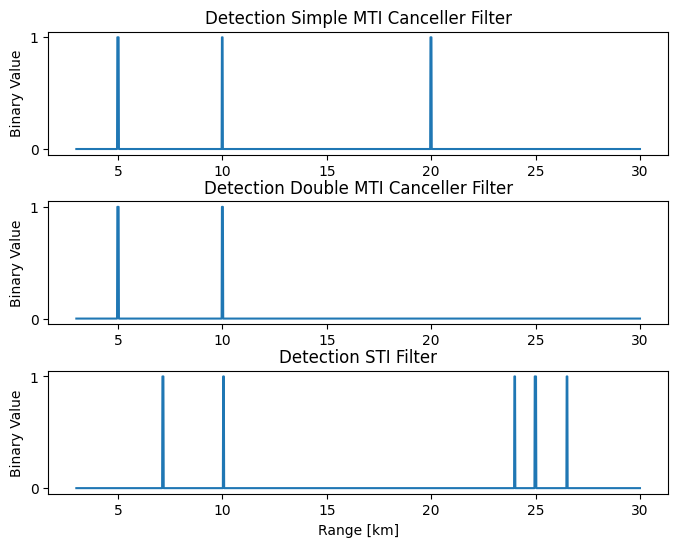

In [67]:
def DET(S):
  DET = np.zeros(len(S[0]))

  N = 20
  G = 2
  p = 0.001

  n = len(S)

  for j in range(0,n):
    y = S[j]
    C = CFAR(y, N, G, p)


    for i in range(1, len(S[0])-2):
      if(y[i]>C[i] or y[i+1]>C[i+1]):
        DET[i]+=1

  for i in range(0, len(DET)):
      if(DET[i]<n/2):
        DET[i] = 0
      else:
        DET[i] = 1

  return DET

DET_MTI = DET(np.abs(y_MTI)**2)
DET_MTI2 = DET(np.abs(y_MTI2)**2)
DET_STI = DET(np.abs(y_STI)**2)

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=0.38)

ax[0].plot(rang, DET_MTI)
ax[0].set_ylabel("Binary Value")
ax[0].set_title("Detection Simple MTI Canceller Filter")
ax[0].set_yticks([0, 1], ['0', '1'])  # Labels on y-axis


ax[1].plot(rang, DET_MTI2)
ax[1].set_ylabel("Binary Value")
ax[1].set_title("Detection Double MTI Canceller Filter")
ax[1].set_yticks([0, 1], ['0', '1'])  # Labels on y-axis


ax[2].plot(rang, DET_STI)
ax[2].set_ylabel("Binary Value")
ax[2].set_title("Detection STI Filter")
ax[2].set_yticks([0, 1], ['0', '1'])  # Labels on y-axis

ax[2].set_xlabel("Range [km]")
